<a href="https://colab.research.google.com/github/khpankiv/Kaggle_learning/blob/main/ell_feedback_regres_1_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**For using in Colab**

regresion
measure distanse (the accepted error with rare numbers calculate from usual classes


# **Setup**

In [2]:
#A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 4.8 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 462 kB 62.5 MB/s 
     |████████████████████████████████| 1.4 MB 48.9 MB/s 
     |████████████████████████████████| 5.8 MB 53.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

# **Read the datasets**

In [4]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c feedback-prize-english-language-learning
!mkdir ELL
! unzip feedback-prize-english-language-learning.zip -d ELL

Saving embedded.npy to embedded.npy
Saving kaggle.json to kaggle.json
  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 164MB/s]
Archive:  feedback-prize-english-language-learning.zip
  inflating: ELL/sample_submission.csv  
  inflating: ELL/test.csv            
  inflating: ELL/train.csv           


In [ ]:
#test= pd.read_csv("./ELL/test.csv")
#test_sub=pd.read_csv("./ELL/sample_submission.csv")

In [210]:
data= pd.read_csv("./ELL/train.csv")
#to make dataset smaller))
#train = train.sample(frac = 0.5)
#test = train.iloc[:,0:2]
#test_sub = train.iloc[:,[0,2]]

(array([  10.,   27.,  315.,  790.,    0., 1096.,  988.,  534.,  125.,
          26.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

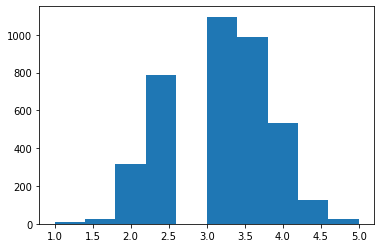

In [211]:
plt.hist(data['cohesion'])

In [147]:
data = data.loc[data['cohesion']<4.5,['text_id','full_text', 'cohesion']]
data = data.loc[data['cohesion']>1.5,['text_id','full_text', 'cohesion']]
num = data.shape[0]
num_train = round(num*0.8)

Data preprocessing: changing grades into integer

Change grades from [1, 1.5, 2.....4.5, 5] to [0,1,2,3,4,5...8]

And select only grades for cohesion

In [149]:
num_text = data.shape[0]
columns = ['text_id','cohesion']
train_X_all = data.full_text.values
#train_X = train_X_all[:2500]
train_Y = (data[:num_train].cohesion.values)*2-2
#  uncomment for one-hot
#train_Y = tf.keras.utils.to_categorical(train_Y_n) 
#test_X = train_X
#test_X = data[2500:].full_text.values
test_Y = data[num_train:].cohesion.values*2-2

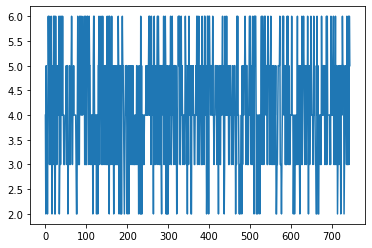

In [162]:
plt.plot(test_Y)

Calculate the frequency of each grade to balance waightes while training

In [200]:
distribution = data['cohesion']. value_counts(1).sort_index()
distr = dict(zip(range(5), 1/distribution.values))

In [8]:
del train

# **Define the model**
A simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense with Softmax output and a Dropout layer.

Add BERT models

In [150]:
tfhub_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2"

Preprocess text data. Embed them into arrays of 256 numbers

In [151]:
  preprocess_model = hub.KerasLayer(tfhub_preprocess)
  encoder_inputs = preprocess_model(train_X_all) 
  encoder = hub.KerasLayer(tfhub_encoder, trainable=False)
  outputs = encoder(encoder_inputs)
  output = outputs['pooled_output']

Save Embedded input data

(array([   5.,   10.,   17.,   20.,   59.,   63.,  150.,  276.,  711.,
        2412.]),
 array([-0.8392362 , -0.6553623 , -0.4714884 , -0.2876145 , -0.10374059,
         0.08013332,  0.2640072 ,  0.44788113,  0.63175505,  0.81562895,
         0.99950284], dtype=float32),
 <a list of 10 Patch objects>)

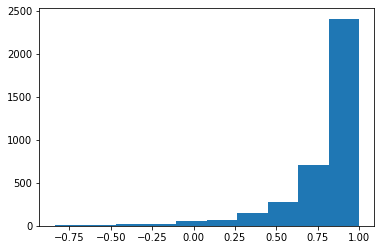

In [264]:
plt.hist(output[:,10])

In [ ]:
np.save('embedded',output)

**Load Embeddent input Data**

In [9]:
output = np.load('embedded.npy') 

In [154]:
train_X = output[:num_train]
test_X = output[num_train:]

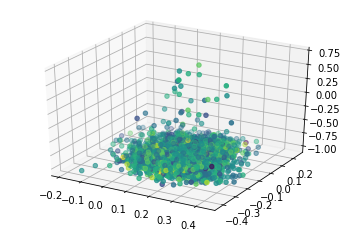

In [62]:
fig = plt.figure(2)
fig.hist
#plt.subplot(2,1,2)
#plt.plot(train_Y[:100],'b', label = 'Gredes_int')


In [156]:
batch_size = 1

In [236]:
def build_classifier_model(activ,num_output):
  input = tf.keras.layers.Input(shape = (256), batch_size = batch_size)
  output = tf.keras.layers.Dense(256,activation='ReLU')(input)
  output = tf.keras.layers.Dense(128, activation='ReLU')(output) 
  output = tf.keras.layers.Dense(128, activation='ReLU')(output)
  output = tf.keras.layers.Dense(128, activation='ReLU')(output)
 # output = tf.keras.layers.Dense(9, activation='ReLU')(output)
  #net_1 = tf.keras.layers.Dropout(0.1)(output_2)
  net_1 = tf.keras.layers.Dense(num_output, activation = activ)(output)
  return tf.keras.Model(input, net_1)

In [237]:
classifier_model = build_classifier_model('linear',1)

In [14]:
classifier_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 256)]                0         
                                                                 
 dense (Dense)               (1, 256)                  65792     
                                                                 
 dense_1 (Dense)             (1, 128)                  32896     
                                                                 
 dense_2 (Dense)             (1, 64)                   8256      
                                                                 
 dense_3 (Dense)             (1, 32)                   2080      
                                                                 
 dense_4 (Dense)             (1, 1)                    33        
                                                                 
Total params: 109,057
Trainable params: 109,057
Non-trainable

# **Model training**

In [ ]:
   # from google3.third_party.tensorflow.core.protobuf import rewriter_config_pb2
    #    config_proto = tf.ConfigProto()
#    off = rewriter_config_pb2.RewriterConfig.OFF
 #   config_proto.graph_options.rewrite_options.arithmetic_optimization = off
  #    session = tf.Session(config=config_proto)

In [238]:
loss = tf.keras.losses.MeanSquaredError(reduction = 'sum')
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss = loss,
                         metrics = 'mse')

In [ ]:
#board = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [ ]:
#restore = tf.keras.callbacks.BackupAndRestore('/ELL')

In [160]:
epochs = 50

In [244]:
history = classifier_model.fit(x = train_X,
                               y = train_Y,
                               epochs = epochs,
                               batch_size=batch_size, 
                               #callbacks=[restore],
                               #class_weight = distr,
                               validation_data =[test_X, test_Y])

Epoch 1/50
2978/2978 [==============================] - 32s 11ms/step - loss: 1.1214 - mse: 1.1214 - val_loss: 1.2664 - val_mse: 1.2664
Epoch 2/50
2978/2978 [==============================] - 41s 14ms/step - loss: 1.1240 - mse: 1.1240 - val_loss: 1.2956 - val_mse: 1.2956
Epoch 3/50
2978/2978 [==============================] - 38s 13ms/step - loss: 1.1401 - mse: 1.1401 - val_loss: 1.2351 - val_mse: 1.2351
Epoch 4/50
2978/2978 [==============================] - 37s 12ms/step - loss: 1.1421 - mse: 1.1421 - val_loss: 1.3293 - val_mse: 1.3293
Epoch 5/50
2978/2978 [==============================] - 40s 13ms/step - loss: 1.1241 - mse: 1.1241 - val_loss: 1.2548 - val_mse: 1.2548
Epoch 6/50
2978/2978 [==============================] - 23s 8ms/step - loss: 1.1293 - mse: 1.1293 - val_loss: 1.2474 - val_mse: 1.2474
Epoch 7/50
2978/2978 [==============================] - 17s 6ms/step - loss: 1.1267 - mse: 1.1267 - val_loss: 1.3294 - val_mse: 1.3294
Epoch 8/50
2978/2978 [============================

In [26]:
classifier_model.save('saved_model2')

In [ ]:
!tar -czvf model2.tar.gz saved_model1

saved_model1/
saved_model1/variables/
saved_model1/variables/variables.index
saved_model1/variables/variables.data-00000-of-00001
saved_model1/saved_model.pb
saved_model1/assets/
saved_model1/keras_metadata.pb


In [ ]:
files.download('model2.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model evaluation**

In [245]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


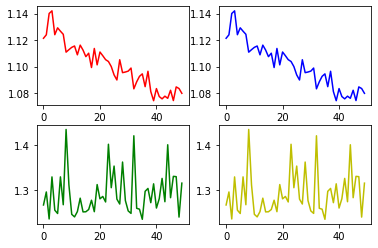

In [247]:
#i = range(epochs)
plt.figure(1)
plt.title('Model evaluation')
plt.legend()

plt.subplot(2,2,1)
plt.plot(history_dict['loss'],'r',label = "Training loss")

plt.subplot(2,2,2)
plt.plot(history_dict['mse'],'b',label = "Training MSE")

plt.subplot(2,2,3)
plt.plot(history_dict['val_loss'],'g',label = "Validadion loss")

plt.subplot(2,2,4)
plt.plot(history_dict['val_mse'],'y',label = "Validation MSE")

In [ ]:
#t = test_X[0:5]

In [248]:
test_Y_n = classifier_model.predict(test_X,verbose = 1)

24/24 [==============================] - 1s 34ms/step


In [249]:
#for classificatio
#pred_test_Y=(np.argmax(test_Y_n,1)+2)/2
#for regression
pred_Y = np.reshape((np.round(test_Y_n)+2)/2,test_Y.size)
mcrmse_test = np.sqrt(np.sum(np.square(pred_Y-test_Y))/num_text)
print('MCRMSE = ',mcrmse_test) 

MCRMSE =  0.7233955358325228


In [253]:
min(pred_Y)

2.5

MCRMSE =  0.617284905504784 5 epochs

MCRMSE =  0.6333342304873718 10 epochs

MCRMSE =  0.6012389019459027 10 epochs bached 32

MCRMSE =  0.6137303634466796 5 epochs batched tuned

MCRMSE =  0.5939521873178615 5 epochs 2 dense
  
MCRMSE =  0.5827963961318415 10 epochs 5 dense

MCRMSE =  0.47713642331475004  1 epoch 3 dense shaped

regression:full +3x128+3x64

MCRMSE =  1.1748504531717312

Epoch 100/100 ====>loss: 21.0348 - mse: 2.3953



regression:full +5x128

MCRMSE =  0.6841

Epochs:300 ======> loss: 16.6 - mse: 1.99




regression:full all layers

MCRMSE =  0.568

Epochs:400 ======> loss: 6.66 - mse: 1.03


# **create output file**

In [212]:
#np.reshape(pred_Y,(num_text))
result = [test_id, pred_Y]
df_result = pd.DataFrame(np.transpose(result),columns = columns)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: ignored

clear the /kaggle/working

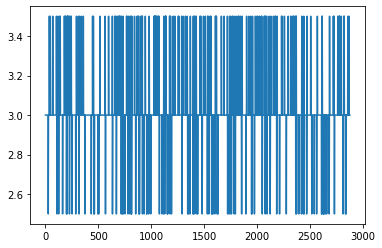

In [88]:
i = range(num_text)
plt.plot(i,df_result['cohesion'])

In [ ]:
df_result.to_csv('/kaggle/working/submission.csv')